In [2]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
import folium
import os
from tqdm.notebook import tqdm
import json
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [21, 10]
sns.set()

/Users/captainbanana/my_env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
all_claims = pd.read_csv('moscow_claims_2023-09-01.csv')
all_claims = all_claims.drop_duplicates('claim_uuid')

In [4]:
yandex_traces = pd.read_csv('traces_moscow_2023-09-01.csv')

In [5]:
all_claims = all_claims[all_claims['trace_id'].isin(set(yandex_traces['trace_id']))]

In [6]:
ready_routes = pd.read_pickle('random_routes_2023-09-01.pkl')

In [7]:
traces = pd.Series(all_claims['trace_id'].unique())

In [8]:
input_config = {
    "use_initial_solution": True,
    "inequalities_to_use": [1, 3, 4, 5, 6, 7, 8, 10],
    "batch_size": 4
}
with open('input_config.json', 'w+') as f:
    json.dump(input_config, f)

In [34]:
traces_sample = traces.sample(200)


In [69]:
sh_economies = []
yandex_sh_economies = []

list_of_dicts = []

for trace_id in tqdm(traces_sample):
    claims = all_claims[all_claims['trace_id'] == trace_id]
    claims.to_csv('claims.csv', index=False)

    yandex_sh_economy = yandex_traces[yandex_traces['trace_id'] == trace_id]['sh_economy'].iloc[0]
    yandex_sh_economies.append(yandex_sh_economy)

    best_sh_economy = 0
    for route_len in [2, 3, 4, 5, 6, 7, 8]:
        if len(claims) < route_len:
            continue
        input_config = {
            "use_initial_solution": True,
            "inequalities_to_use":[1, 3, 4, 5, 6, 7, 8],
            "batch_size": route_len
        }
        with open('input_config.json', 'w+') as f:
            json.dump(input_config, f)
        
        os.system(f'/Users/captainbanana/CLionProjects/routes/cmake-build-debug/routes')
        with open('output.json') as f:
            result = json.load(f)
        list_of_dicts.append({
            "trace_id": trace_id,
            "claims_count": result['claims_count'],
            'result_code_str': result['result_code_str'],
            'sh_economy': result['sh_economy'],
            'seconds_spent': result['seconds_spent'],
            'route_len': route_len
        })
        best_sh_economy = max(best_sh_economy, result['sh_economy'])

    if best_sh_economy > 0:
        sh_economies.append(best_sh_economy)


  0%|          | 0/200 [00:00<?, ?it/s]

      0: obj =  -0.000000000e+00 inf =   5.000e+00 (5)
     10: obj =  -9.028616376e+00 inf =   3.331e-16 (0)
*    31: obj =   1.126310222e+00 inf =   7.694e-16 (0)
+    31: mip =     not found yet <=              +inf        (1; 0)
Solution found by heuristic: -5.42257056472
+    50: mip =  -5.422570565e+00 <=     tree is empty   0.0% (0; 5)
0.001024 seconds taken on optimization
claims_sum_distance - route_len: -5.42257
sh_economy: -0.212755
      0: obj =  -0.000000000e+00 inf =   5.000e+00 (5)
     23: obj =  -3.085327249e+01 inf =   1.571e-15 (0)
*    61: obj =  -1.196964740e+00 inf =   1.861e-14 (0)
+    61: mip =     not found yet <=              +inf        (1; 0)
Solution found by heuristic: -14.6181123309
+    71: >>>>>  -8.224369522e+00 <=  -1.567917296e+00  80.9% (2; 0)
+    85: mip =  -8.224369522e+00 <=     tree is empty   0.0% (0; 3)
0.001471 seconds taken on optimization
claims_sum_distance - route_len: -8.22437
sh_economy: -1.98753
      0: obj =  -0.000000000e+00 inf 

In [73]:
df = pd.DataFrame(list_of_dicts)
df = df[df['sh_economy'] > 0]


In [78]:
df['sh_economy'].mean()

0.19526422056768558

Text(0.5, 1.0, 'sh_economy from batch size')

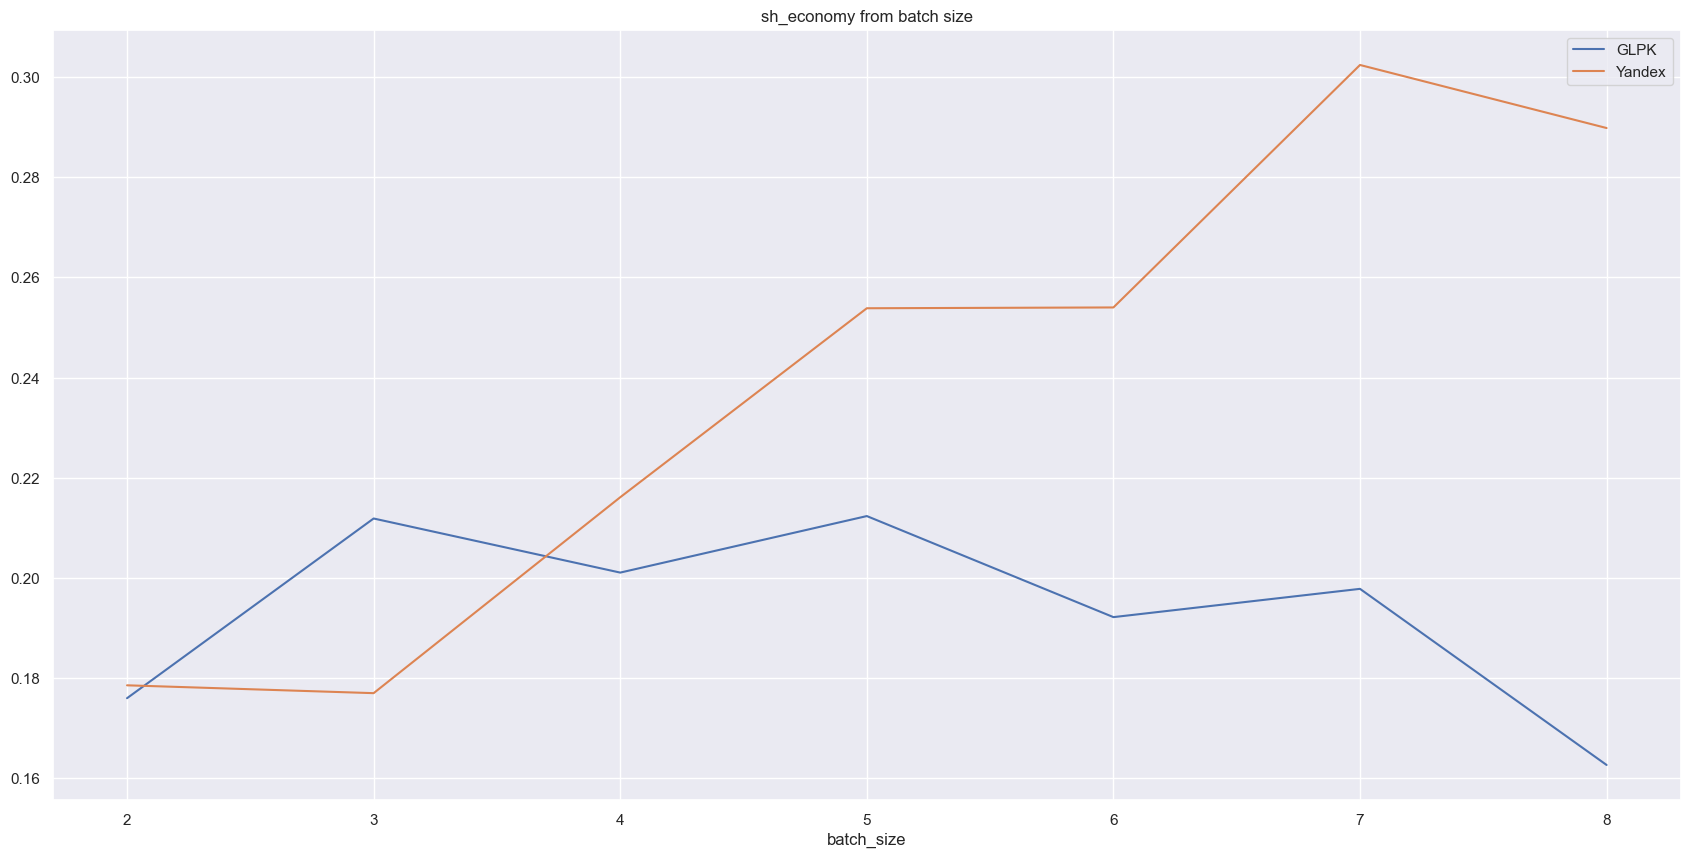

In [91]:
df.groupby('route_len')['sh_economy'].mean().plot(label='GLPK')
yandex[yandex['batch_size'] < 9].groupby('batch_size')['sh_economy'].mean().plot(label='Yandex')
plt.legend()
plt.title('sh_economy from batch size')

In [81]:
yandex = pd.read_clipboard()

Text(0.5, 1.0, 'sh_economy distribution')

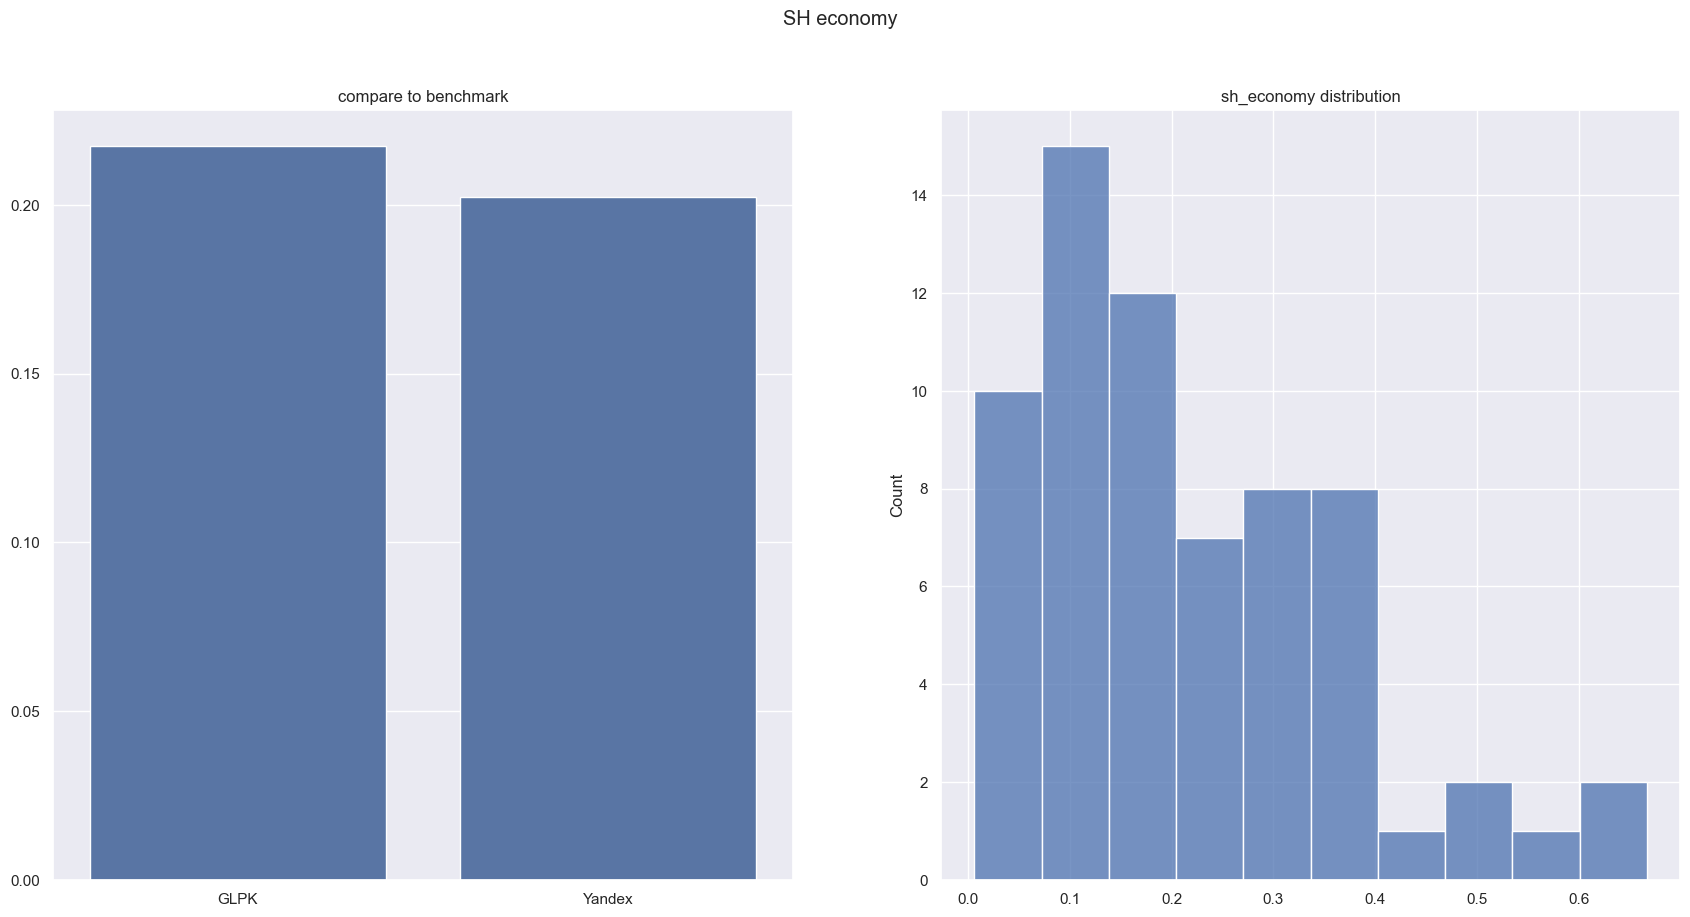

In [68]:
# [1, 3, 4, 5, 6, 7, 8]

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('SH economy')

sns.barplot(ax=ax1, x=['GLPK', 'Yandex'], y=[np.mean(sh_economies), np.mean(yandex_sh_economies)])
ax1.set_title('compare to benchmark')

sns.histplot(ax=ax2, x=sh_economies, bins=10)
ax2.set_title('sh_economy distribution')

Text(0.5, 1.0, 'sh_economy distribution')

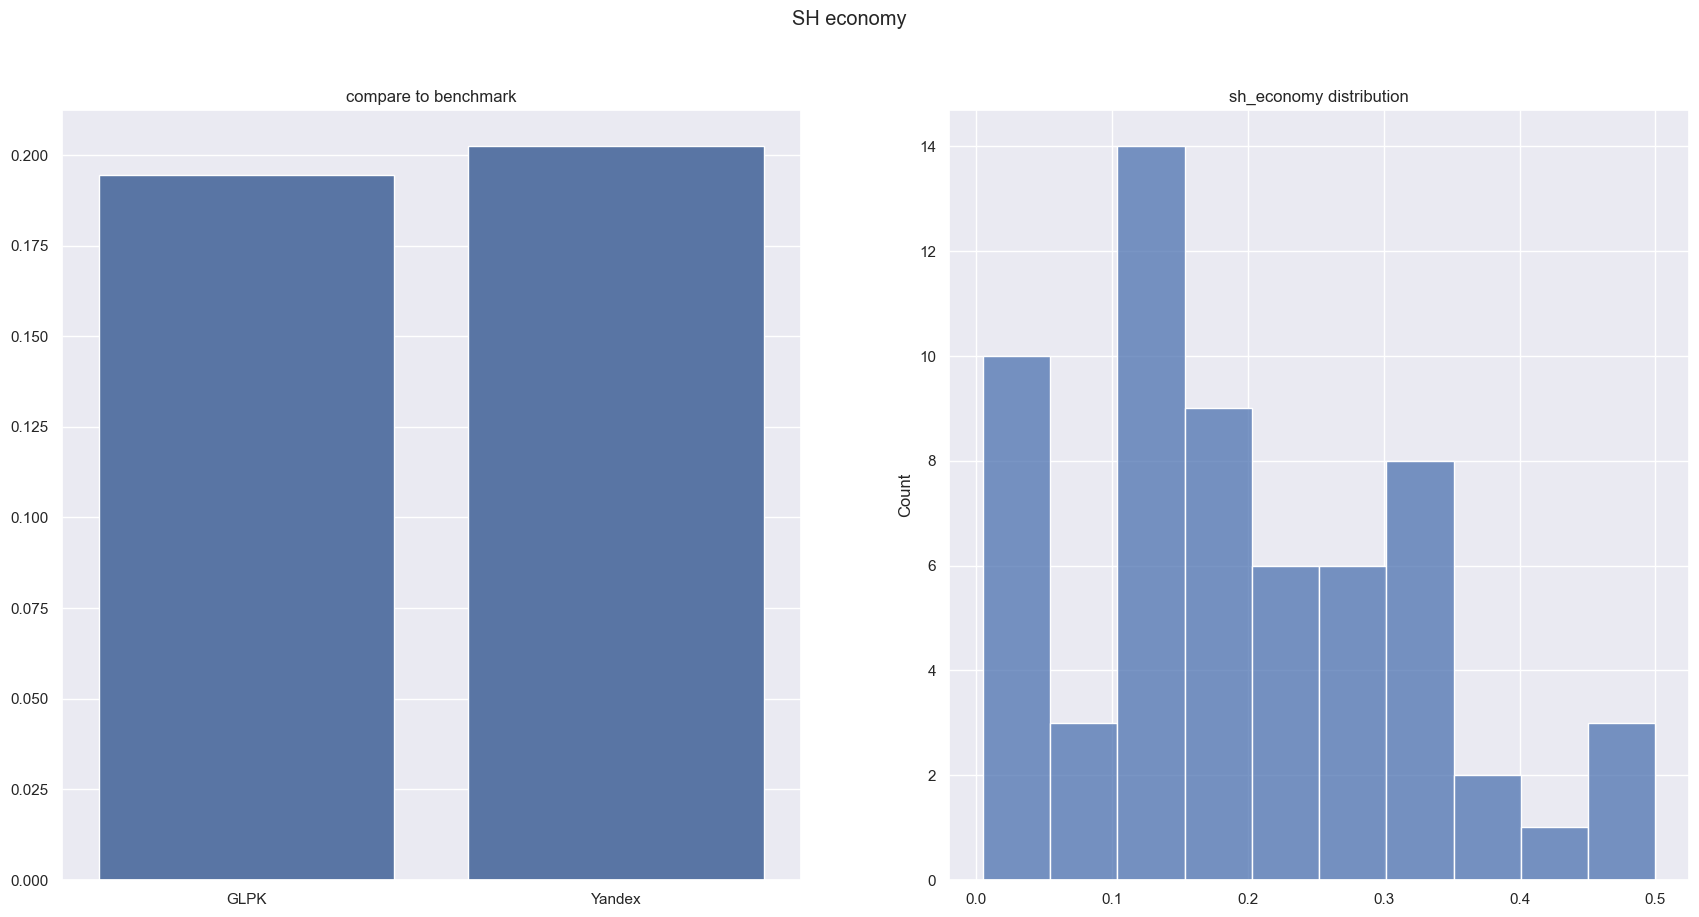

In [66]:
# [2, 3, 4, 5, 6, 7, 8, 10]

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('SH economy')

sns.barplot(ax=ax1, x=['GLPK', 'Yandex'], y=[np.mean(sh_economies), np.mean(yandex_sh_economies)])
ax1.set_title('compare to benchmark')

sns.histplot(ax=ax2, x=sh_economies, bins=10)
ax2.set_title('sh_economy distribution')

In [40]:
sh_economies

[0.102934,
 0.310169,
 0.114049,
 0.0944311,
 0.315542,
 0.379155,
 0.13107,
 0.183382,
 0.364252,
 0.119473,
 0.141759,
 0.378957,
 0.302969,
 0.148649,
 0.00711752,
 0.0112888,
 0.01173,
 0.15051,
 0.337653,
 0.168355,
 0.325131,
 0.255486,
 0.0157443,
 0.0236549,
 0.268291,
 0.0479436,
 0.105561,
 0.212478,
 0.127029,
 0.0140361,
 0.318132,
 0.5,
 0.206782,
 0.322292,
 0.133779,
 0.289752,
 0.107038,
 0.0257104,
 0.206095,
 0.326792,
 0.0260421,
 0.5,
 0.110955,
 0.327682,
 0.149809,
 0.168344,
 0.232887,
 0.336605,
 0.0503187,
 0.0648326,
 0.109444,
 0.268068,
 0.198509,
 0.5,
 0.292843,
 0.477897,
 0.113645,
 0.198285,
 0.0871036,
 0.347223,
 0.208187,
 0.00613557,
 0.0408572,
 0.389283,
 0.159474,
 0.422946]

In [37]:
np.mean(sh_economies)

0.20323171954545452

In [33]:
np.mean(yandex_sh_economies)

0.2003516260215955

In [103]:
all_claims['trace_id'].value_counts().sample(20)

trace_id
bbdf05264bc64486b04d4cbf83c2cd13    13
c68fca926df84609a947ad3eb4c0d8b8     4
b9f8dbd2c5374990b3a18f7bcf710028    29
5b3774b671654608968f93cb0b744c93     3
267673f0a537492a9e697c383919c360     2
9c0f492827b844a69872e7fea9694772     1
65a018520c86429eb1c6014e644260cf     7
dd1b9c4e614645189cb59a59735a9050     3
162853d79a5941c49d4d61fa4d887fcc     4
3ce20421c19b4b2aa322b4b13aee2a08     4
a9e433897b514297ae4a8c21d298c4b6     4
af4200aa9f2f4d3c8726708db9c9c17a     2
2d8b441928dd48b79beb77dd50f6f963     3
6d9a6952ec294fa081aca79445b7531e     1
a3b452e146f542b99a61a0532f1d260e     5
a6dde3069dd84bb5971a9a109c653b4f     7
2bec673acc064827a03b0e7423f40c78     1
c7f698e21f9341e0849f115fe03614d7     2
738c45f101e44a9d9b3a8bcd2dd475e3     5
0fd1023e76034ab4b6fef17ddd931288     4
Name: count, dtype: int64

In [185]:
list_of_dicts = []
for trace_id in tqdm(traces.sample(20)):
    claims = all_claims[all_claims['trace_id'] == trace_id]
    claims.to_csv('claims.csv', index=False)

    for route_len in [2, 4, 6, 8]:
        input_config = {
            "use_initial_solution": True,
            "inequalities_to_use": [1, 3, 4, 5, 6, 7, 8, 10],
            "batch_size": 4
        }
        with open('input_config.json', 'w+') as f:
            json.dump(input_config, f)
        
        os.system(f'/Users/captainbanana/CLionProjects/routes/cmake-build-debug/routes {route_len}')
        with open('output.json') as f:
            result = json.load(f)
        list_of_dicts.append({
            "trace_id": trace_id,
            "claims_count": result['claims_count'],
            'result_code_str': result['result_code_str'],
            'sh_economy': result['sh_economy'],
            'seconds_spent': result['seconds_spent'],
            'route_len': route_len
        })

        print(result)

        

  0%|          | 0/20 [00:00<?, ?it/s]

*     0: obj =  -0.000000000e+00 inf =   0.000e+00 (246)
*    97: obj =   2.797377257e+00 inf =   3.495e-15 (0)
LP is solved
0.03126 seconds taken on optimization
sh_economy: 0.311344
{'seconds_spent': 0.03126, 'sh_economy': 0.311344, 'points_in_route': 2, 'claims_count': 9, 'result_code_str': 'optimal'}
*     0: obj =  -0.000000000e+00 inf =   0.000e+00 (574)
*   217: obj =   4.831715350e+00 inf =   2.833e-15 (0) 1
LP is solved
0.546834 seconds taken on optimization
sh_economy: 0.326362
{'seconds_spent': 0.546834, 'sh_economy': 0.326362, 'points_in_route': 4, 'claims_count': 9, 'result_code_str': 'optimal'}
*     0: obj =  -0.000000000e+00 inf =   0.000e+00 (902)
*   452: obj =   6.439871436e+00 inf =   4.677e-13 (0) 2
LP is solved
7.9718 seconds taken on optimization
sh_economy: 0.188326
{'seconds_spent': 7.9718, 'sh_economy': 0.188326, 'points_in_route': 6, 'claims_count': 9, 'result_code_str': 'time limit'}
*     0: obj =  -0.000000000e+00 inf =   0.000e+00 (1230)
*   600: obj =   

In [186]:
list_of_dicts

[{'trace_id': 'db1d33bbbc804dcda28d2e2b0a882cdf',
  'claims_count': 9,
  'result_code_str': 'optimal',
  'sh_economy': 0.311344,
  'seconds_spent': 0.03126,
  'route_len': 2},
 {'trace_id': 'db1d33bbbc804dcda28d2e2b0a882cdf',
  'claims_count': 9,
  'result_code_str': 'optimal',
  'sh_economy': 0.326362,
  'seconds_spent': 0.546834,
  'route_len': 4},
 {'trace_id': 'db1d33bbbc804dcda28d2e2b0a882cdf',
  'claims_count': 9,
  'result_code_str': 'time limit',
  'sh_economy': 0.188326,
  'seconds_spent': 7.9718,
  'route_len': 6},
 {'trace_id': 'db1d33bbbc804dcda28d2e2b0a882cdf',
  'claims_count': 9,
  'result_code_str': 'time limit',
  'sh_economy': 0,
  'seconds_spent': 8.00813,
  'route_len': 8},
 {'trace_id': '492e87cf1d024cdc96bc5668fda85989',
  'claims_count': 84,
  'result_code_str': 'time limit',
  'sh_economy': 0.5,
  'seconds_spent': 10.184,
  'route_len': 2},
 {'trace_id': '492e87cf1d024cdc96bc5668fda85989',
  'claims_count': 84,
  'result_code_str': 'error',
  'sh_economy': 0,
  

In [151]:
with open('output.json') as f:
            result = json.load(f)

In [300]:
claims.drop_duplicates('claim_uuid')

,Unnamed: 0,claim_uuid,destination_lat,destination_lon,source_location_lat,source_location_lon,trace_id,zone_id
137773,137773,1cfdb6a20b114ab5b304bcdf73ba0137,55.730100,37.641588,55.698585,37.596322,4ea1ce53dfe94f1b99d07a974ab84be1,moscow
496363,496363,e2b2519610b64a24b9ce7df1fbeed4ed,55.658175,37.617141,55.651467,37.612596,4ea1ce53dfe94f1b99d07a974ab84be1,moscow
542475,542475,fa4cb599a4594069b139b80d0dd1f080,55.797800,37.377449,55.675317,37.778089,4ea1ce53dfe94f1b99d07a974ab84be1,moscow
884886,884886,37e8b12d661b4a17b2c3c54c6e643a8c,55.823024,37.929881,55.617822,37.446424,4ea1ce53dfe94f1b99d07a974ab84be1,moscow


In [301]:
claims

,Unnamed: 0,claim_uuid,destination_lat,destination_lon,source_location_lat,source_location_lon,trace_id,zone_id
137773,137773,1cfdb6a20b114ab5b304bcdf73ba0137,55.730100,37.641588,55.698585,37.596322,4ea1ce53dfe94f1b99d07a974ab84be1,moscow
496363,496363,e2b2519610b64a24b9ce7df1fbeed4ed,55.658175,37.617141,55.651467,37.612596,4ea1ce53dfe94f1b99d07a974ab84be1,moscow
532004,532004,e2b2519610b64a24b9ce7df1fbeed4ed,55.654162,37.610736,55.651467,37.612596,4ea1ce53dfe94f1b99d07a974ab84be1,moscow
542475,542475,fa4cb599a4594069b139b80d0dd1f080,55.797800,37.377449,55.675317,37.778089,4ea1ce53dfe94f1b99d07a974ab84be1,moscow
674574,674574,e2b2519610b64a24b9ce7df1fbeed4ed,55.648514,37.602795,55.651467,37.612596,4ea1ce53dfe94f1b99d07a974ab84be1,moscow
884886,884886,37e8b12d661b4a17b2c3c54c6e643a8c,55.823024,37.929881,55.617822,37.446424,4ea1ce53dfe94f1b99d07a974ab84be1,moscow
1037520,1037520,e2b2519610b64a24b9ce7df1fbeed4ed,55.656367,37.592195,55.651467,37.612596,4ea1ce53dfe94f1b99d07a974ab84be1,moscow


In [104]:
claims = all_claims[all_claims['trace_id'] == 'b9f8dbd2c5374990b3a18f7bcf710028']
claims.to_csv('claims.csv', index=False)
len(claims)

29

In [148]:
os.system('/Users/captainbanana/CLionProjects/routes/cmake-build-debug/routes 9')

      0: obj =  -5.300246792e+01 inf =   4.200e+01 (19)
    481: obj =  -1.362721874e+02 inf =   1.500e-09 (0) 3
*  5939: obj =   8.066320647e+01 inf =   1.054e-06 (33189) 22
* 12417: obj =   1.188464335e+02 inf =   7.762e-15 (0) 24
+ 12417: mip =     not found yet <=              +inf        (1; 0)
Solution found by heuristic: -115.361596552
+ 13995: mip =  -1.153615966e+02 <=   1.186964751e+02 202.9% (5; 0)
+ 14636: mip =  -1.153615966e+02 <=   1.186964751e+02 202.9% (12; 0)
+ 20429: mip =  -1.153615966e+02 <=   1.186964751e+02 202.9% (11; 1)
31.3994 seconds taken on optimization
sh_economy: -1.58724


0

In [114]:
edges = pd.read_csv('output_edges.csv')
edges = edges[edges['value'] > 0]

In [115]:
len(claims)

29

In [116]:
map_center_lat = claims[['source_location_lat', 'destination_lat']].values.flatten().mean()
map_center_lon = claims[['source_location_lon', 'destination_lon']].values.flatten().mean()
m = folium.Map(location=[map_center_lat, map_center_lon], zoom_start=12)

In [117]:
for idx, row in claims.iterrows():
    src_point = [row['source_location_lat'], row['source_location_lon']]
    dst_point = [row['destination_lat'], row['destination_lon']]

    # Добавление маркеров
    claim_id = row['claim_uuid']

    folium.Marker(src_point, icon=folium.Icon(color='blue'), popup=f"{claim_id}_source").add_to(m)
    folium.Marker(dst_point, icon=folium.Icon(color='red'), popup=f"{claim_id}_destination").add_to(m)

    # Соединение точек линией красного цвета
    # folium.PolyLine(locations=[src_point, dst_point], color='red').add_to(m)


must have: 1 or 2, 4, 5, 6, 7, 

In [118]:
possible_subsets = [
    {1, 3, 4, 5, 6, 7, 8, 10}
    {2, 3, 4, 5, 6, 7, 8, 10},
    {1, 4, }
]

SyntaxError: invalid syntax (2549012179.py, line 3)

In [119]:
edges

,edge_id,value
214,b2643aa9263a48f5bc62f1cc3a57196b_source_817586a5204942aa990b50166e70e58a_source,4
521,817586a5204942aa990b50166e70e58a_source_1822bbde715644e8bc199c334871737f_destination,5
638,817586a5204942aa990b50166e70e58a_destination_8b66618d934746198ead259283e701ed_destination,9
941,1822bbde715644e8bc199c334871737f_source_b2643aa9263a48f5bc62f1cc3a57196b_source,3
950,ec6e01b48ff64c1686ecb655e02506de_source_1822bbde715644e8bc199c334871737f_source,2
981,b2643aa9263a48f5bc62f1cc3a57196b_destination_817586a5204942aa990b50166e70e58a_destination,8
1066,1822bbde715644e8bc199c334871737f_destination_ec6e01b48ff64c1686ecb655e02506de_destination,6
2456,ec6e01b48ff64c1686ecb655e02506de_destination_b2643aa9263a48f5bc62f1cc3a57196b_destination,7
2825,8b66618d934746198ead259283e701ed_source_ec6e01b48ff64c1686ecb655e02506de_source,1


In [120]:
for i, row in edges.iterrows():
    edge_info = row['edge_id'].split('_')
    point1_id, point1_type, point2_id, point2_type = edge_info[0], edge_info[1], edge_info[2], edge_info[3]
    
    # Получение координат для первой точки
    if point1_type == 'source':
        point1 = claims.loc[claims['claim_uuid'] == point1_id, ['source_location_lat', 'source_location_lon']].values[0]
    else:
        point1 = claims.loc[claims['claim_uuid'] == point1_id, ['destination_lat', 'destination_lon']].values[0]
    
    # Получение координат для второй точки
    if point2_type == 'source':
        point2 = claims.loc[claims['claim_uuid'] == point2_id, ['source_location_lat', 'source_location_lon']].values[0]
    else:
        point2 = claims.loc[claims['claim_uuid'] == point2_id, ['destination_lat', 'destination_lon']].values[0]
    
    # Соединение точек линией зеленого цвета
    value = row['value']
    folium.PolyLine(locations=[point1, point2], color='green', html=f'<div style="font-size: 100pt">{value}</div>').add_to(m)


In [121]:
claims

,Unnamed: 0,claim_uuid,destination_lat,destination_lon,source_location_lat,source_location_lon,trace_id,zone_id
145684,145684,1ce297c4b37341f1aa1dc66b8226e340,55.863060,37.372719,55.862681,37.372440,b9f8dbd2c5374990b3a18f7bcf710028,moscow
160042,160042,7730cfb5ed2846649a30799281414e0e,55.517495,37.723762,55.600661,37.539714,b9f8dbd2c5374990b3a18f7bcf710028,moscow
164342,164342,817586a5204942aa990b50166e70e58a,55.800428,37.710063,55.640785,37.657616,b9f8dbd2c5374990b3a18f7bcf710028,moscow
215459,215459,f09cc5d71329447bbe81cb0b3123a79b,55.523993,37.584990,55.513983,37.575783,b9f8dbd2c5374990b3a18f7bcf710028,moscow
227732,227732,1822bbde715644e8bc199c334871737f,55.620667,37.664941,55.711640,37.645312,b9f8dbd2c5374990b3a18f7bcf710028,moscow
227733,227733,4e28041e36dc4f87b00d63d96ba52a9d,55.620631,37.265208,55.609077,37.332429,b9f8dbd2c5374990b3a18f7bcf710028,moscow
227755,227755,423b858a6bb642e0b0f6f463cd9bc723,55.854128,37.351932,55.855153,37.355498,b9f8dbd2c5374990b3a18f7bcf710028,moscow
227765,227765,3a42a32f2e84446c88db48286084f997,55.591330,37.457537,55.592520,37.455489,b9f8dbd2c5374990b3a18f7bcf710028,moscow
227768,227768,0f42e847a6ae49fabe03ef7c1c44a18c,55.598701,37.352287,55.593873,37.351905,b9f8dbd2c5374990b3a18f7bcf710028,moscow
227771,227771,40d2f03cf2b34b07b37b30fed87118bc,55.603608,37.364005,55.593873,37.351905,b9f8dbd2c5374990b3a18f7bcf710028,moscow


In [122]:
m

In [50]:
len(claims)

8

In [261]:
import json
import math

def haversine_distance(coord1, coord2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees).
    """
    # Конвертация десятичных градусов в радианы
    lon1, lat1, lon2, lat2 = map(math.radians, [coord1[0], coord1[1], coord2[0], coord2[1]])
    
    # Формула Хаверсина
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a)) 
    r = 6371 # Радиус земли в км
    return c * r

def calculate_km_savings(data):
    """
    Calculate kilometers savings based on a list of pickup and dropoff points in a route.
    """
    distances_within_requests = 0
    total_route_distance = 0
    previous_point = None
    requests = {}

    # Составление маршрута и расчеты внутри заявок
    for point in data:
        segment_id = point['segment_id']
        coordinate = point['coordinates']
        
        # Запоминание точек в словаре по их segment_id
        if segment_id not in requests:
            requests[segment_id] = {'pickup': None, 'dropoff': None}
        requests[segment_id][point['type']] = coordinate
        
        # Расчет реального маршрута
        if previous_point is not None:
            total_route_distance += haversine_distance(previous_point, coordinate)
        previous_point = coordinate
    
    # Расчет расстояний внутри каждой заявки
    for key, value in requests.items():
        distances_within_requests += haversine_distance(value['pickup'], value['dropoff'])
        
    # Расчет экономии километров
    savings = distances_within_requests - total_route_distance
    return savings

# Пример входных данных
route_data = [
    {
        "coordinates": [
            37.35980590805415,
            55.64116834226529
        ],
        "segment_id": "c1507059d3344f39aed9220f3da525f2",
        "type": "pickup"
    },
    {
        "coordinates": [
            37.3274612,
            55.6405792
        ],
        "segment_id": "c1507059d3344f39aed9220f3da525f2",
        "type": "dropoff"
    },
    {
        "coordinates": [
            37.324308352397345,
            55.695179564002586
        ],
        "segment_id": "1b960262f5ed4717a800101831e0250a",
        "type": "pickup"
    },
    {
        "coordinates": [
            37.617752,
            55.763949
        ],
        "segment_id": "1b960262f5ed4717a800101831e0250a",
        "type": "dropoff"
    }
]

# Вызов функции калькуляции экономии километров
savings = calculate_km_savings(route_data)
print(f"Savings in km: {savings:.2f} kilometers")

Savings in km: -6.07 kilometers
